In [ ]:
##CS404 Artifical Intelligence Project
##Supplementary code to go with paper
##Adnan Silajdzic
##Edin Ziga
##Mirza Redzepovic

In [4]:
import os
import numpy as np
import pydot
import graphviz
import random
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from tqdm import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
# Dense layer
class Layer_Dense :
    # Layer initialization
    def __init__ ( self , n_inputs , n_neurons ,
                weight_regularizer_l1 = 0 , weight_regularizer_l2 = 0 ,
                bias_regularizer_l1 = 0 , bias_regularizer_l2 = 0 ):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros(( 1 , n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    # Forward pass
    def forward ( self , inputs ):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    # Backward pass
    def backward ( self , dvalues ):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0 , keepdims = True )
        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0 :
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0 ] = - 1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0 :
            self.dweights += 2 * self.weight_regularizer_l2 * \
            self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0 :
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0 ] = - 1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0 :
            self.dbiases += 2 * self.bias_regularizer_l2 * \
            self.biases
            # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)
        

In [9]:
class Activation_TanH:
    # Forward pass
    def forward(self, inputs):
        self.output = np.tanh(inputs)
        
    # Backward pass
    def backward(self, dvalues):
        # Calculate derivative of tanh function
        derivative = 1 - self.output**2
        # Chain rule
        self.dinputs = dvalues * derivative


In [11]:
class Activation_Sigmoid :
    # Forward pass
    def forward ( self , inputs ):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / ( 1 + np.exp( - inputs))
    # Backward pass
    def backward ( self , dvalues ):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * ( 1 - self.output) * self.output

In [15]:
# Adam optimizer
class Optimizer_Adam :
    # Initialize optimizer - set settings
    def __init__ ( self , learning_rate = 0.001 , decay = 0. , epsilon = 1e-7 ,
    beta_1 = 0.9 , beta_2 = 0.999 ):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    # Call once before any parameter updates
    def pre_update_params ( self ):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
            ( 1. / ( 1. + self.decay * self.iterations))
    # Update parameters
    def update_params ( self , layer ):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr (layer, 'weight_cache' ):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * \
            layer.weight_momentums + \
            ( 1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
            layer.bias_momentums + \
            ( 1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            ( 1 - self.beta_1 ** (self.iterations + 1 ))
        bias_momentums_corrected = layer.bias_momentums / \
            ( 1 - self.beta_1 ** (self.iterations + 1 ))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            ( 1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            ( 1 - self.beta_2) * layer.dbiases ** 2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            ( 1 - self.beta_2 ** (self.iterations + 1 ))
        bias_cache_corrected = layer.bias_cache / \
            ( 1 - self.beta_2 ** (self.iterations + 1 ))
        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += - self.current_learning_rate * \
            weight_momentums_corrected / \
            (np.sqrt(weight_cache_corrected) +
            self.epsilon)
        layer.biases += - self.current_learning_rate * \
                bias_momentums_corrected / \
                (np.sqrt(bias_cache_corrected) +
                self.epsilon)
    # Call once after any parameter updates
    def post_update_params ( self ):
        self.iterations += 1

In [16]:
# Common loss class
class Loss :
    # Regularization loss calculation
    def regularization_loss ( self , layer ):
        # 0 by default
        regularization_loss = 0
        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0 :
            regularization_loss += layer.weight_regularizer_l1 * \
            np.sum(np.abs(layer.weights))
        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0 :
            regularization_loss += layer.weight_regularizer_l2 * \
            np.sum(layer.weights * \
            layer.weights)
        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0 :
            regularization_loss += layer.bias_regularizer_l1 * \
            np.sum(np.abs(layer.biases))
        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0 :
            regularization_loss += layer.bias_regularizer_l2 * \
            np.sum(layer.biases * \
            layer.biases)
        return regularization_loss
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate ( self , output , y ):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss

In [19]:
# Binary cross-entropy loss
class Loss_BinaryCrossentropy ( Loss ):
    # Forward pass
    def forward ( self , y_pred , y_true ):
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7 , 1 - 1e-7 )
        # Calculate sample-wise loss
        sample_losses = - (y_true * np.log(y_pred_clipped) +
        ( 1 - y_true) * np.log( 1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis =- 1 )
        # Return losses
        return sample_losses
    # Backward pass
    def backward ( self , dvalues , y_true ):
        # Number of samples
        samples = len (dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len (dvalues[ 0 ])
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7 , 1 - 1e-7 )
        # Calculate gradient
        self.dinputs = - (y_true / clipped_dvalues -
        ( 1 - y_true) / ( 1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [5]:
#LOAD IMAGES

# Parameters
imageSize = 48
# Set the desired size (in this case, 28x28)
size = (imageSize, imageSize)

#Directory of chest_xray\train\NORMAL
directory = r"D:\PythonProjects\PneumoniaImagesANN\chest_xray\train\NORMAL"

NormalTraining = []
for filename in tqdm(os.listdir(directory), desc = "Loading Normal Training Data"):
    # Load the image
    image = Image.open(os.path.join(directory, filename))
    image = image.convert('L')
    image = image.resize(size)
    pixels = list(image.getdata())
    pixels_normalized = [pixel/255.0 for pixel in pixels]
    NormalTraining.append(pixels_normalized)
    
#Directory of chest_xray\train\PNEUMONIA
directory = r"D:\PythonProjects\PneumoniaImagesANN\chest_xray\train\PNEUMONIA"

PneumoniaTraining = []
for filename in tqdm(os.listdir(directory), desc = "Loading Pneumonia Training Data"):
    image = Image.open(os.path.join(directory, filename))
    image = image.convert('L')
    image = image.resize(size)
    pixels = list(image.getdata())
    pixels_normalized = [pixel/255.0 for pixel in pixels]
    PneumoniaTraining.append(pixels_normalized)

#Directory of chest_xray\test\NORMAL
directory = r"D:\PythonProjects\PneumoniaImagesANN\chest_xray\test\NORMAL"  
    
NormalTesting = []
for filename in tqdm(os.listdir(directory), desc = "Loading Normal Testing Data"):
    image = Image.open(os.path.join(directory, filename))
    image = image.convert('L')
    image = image.resize(size)
    pixels = list(image.getdata())
    pixels_normalized = [pixel/255.0 for pixel in pixels]
    NormalTesting.append(pixels_normalized)

#Directory of chest_xray\test\PNEUMONIA
directory = r"D:\PythonProjects\PneumoniaImagesANN\chest_xray\test\PNEUMONIA"
    
PneumoniaTesting = []
for filename in tqdm(os.listdir(directory), desc = "Loading Pneumonia Testing Data"):
    # Load the image
    image = Image.open(os.path.join(directory, filename))
    image = image.convert('L')
    image = image.resize(size)
    pixels = list(image.getdata())
    pixels_normalized = [pixel/255.0 for pixel in pixels]
    PneumoniaTesting.append(pixels_normalized)
    
print("Images successfully loaded")
print(f"All images are grayscaled and are {imageSize} by {imageSize}")

training_data = NormalTraining + PneumoniaTraining
testing_data = NormalTesting + PneumoniaTesting

training_labels = [0]*len(NormalTraining) + [1]*len(PneumoniaTraining)
testing_labels = [0]*len(NormalTesting) + [1]*len(PneumoniaTesting)

print(f"Training data size - {len(training_data)}")
print(f"Testing data size - {len(testing_data)}")

Loading Pneumonia Testing Data: 100%|███████████████████████████████████████████████| 390/390 [00:03<00:00, 120.27it/s]

Images successfully loaded
All images are grayscaled and are 48 by 48
Training data size - 5216
Testing data size - 624


In [52]:
##NETWORK RUNNING AND TRAINING

print(f'Training data full size - {len(training_data)}')
print(f'Testing data full size - {len(testing_data)}')
#Parameters
random.seed(10)
trainingDataSize = 46 #Batch Size
testingDataSize = 200 #Test Size
noEpochs = 40

print(f'Training data sample size - {trainingDataSize*noEpochs}')
print(f'Testing data sample size - {testingDataSize}')
print(f'No. epochs selected - {noEpochs}')



dense1 = Layer_Dense( imageSize*imageSize , 1024 , weight_regularizer_l2 = 5e-5 ,
                    bias_regularizer_l2 = 5e-5 )
dense2 = Layer_Dense( 1024 , 512 )
dense3 = Layer_Dense( 512 , 256 )
dense4 = Layer_Dense( 256 , 1 )

activation1 = Activation_TanH()
activation2 = Activation_TanH()
activation3 = Activation_TanH()
activation4 = Activation_Sigmoid()

# Create loss function
loss_function = Loss_BinaryCrossentropy()
# Create optimizer
optimizer = Optimizer_Adam( learning_rate = 0.001 , decay = 0.0001 )

for epoch in tqdm(range(1,noEpochs+1), desc = "Training Network"):
    training_data_sample=[]
    training_labels_sample=[]
    # Training data
    normal_indices = list(range(len(NormalTraining)))
    pneumonia_indices = list(range(len(PneumoniaTraining)))

    for i in range(trainingDataSize):
        randNum = random.randint(0, 1)
        if randNum == 0 and len(normal_indices) > 0:
            randData = random.sample(normal_indices, 1)[0]
            normal_indices.remove(randData)
            training_data_sample.append(NormalTraining[randData])
            training_labels_sample.append(0)
        elif randNum == 1 and len(pneumonia_indices) > 0:
            randData = random.sample(pneumonia_indices, 1)[0]
            pneumonia_indices.remove(randData)
            training_data_sample.append(PneumoniaTraining[randData])
            training_labels_sample.append(1)

    y=np.array(training_labels_sample)
    y = y.reshape( - 1 , 1 )

    dense1.forward(np.array(training_data_sample))
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    dense4.forward(activation3.output)
    activation4.forward(dense4.output)

    data_loss = loss_function.calculate(activation4.output, y)
    regularization_loss = \
        loss_function.regularization_loss(dense1) + \
        loss_function.regularization_loss(dense2)
    loss = data_loss + regularization_loss

    predictions = (activation2.output > 0.5 ) * 1
    accuracy = np.mean(predictions == y)


    # Backward pass
    loss_function.backward(activation4.output, y)
    activation4.backward(loss_function.dinputs)
    dense4.backward(activation4.dinputs)

    activation3.backward(dense4.dinputs)
    dense3.backward(activation3.dinputs)

    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)

    activation1.backward(dense2.dinputs)
    dense1.backward(np.array(activation1.dinputs))

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.update_params(dense4)
    optimizer.post_update_params()




Training data full size - 5216
Testing data full size - 624
Training data sample size - 1840
Testing data sample size - 200
No. epochs selected - 40


Training Network: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.01it/s]


Testing accuracy:  0.840 , Testing loss:  0.350 


In [70]:
##NETWORK ACCURACY TESTING

accuracyCollection = []
precisionCollection =[]
recallCollection=[]
f1_scoreCollection=[]
lossCollection=[]
    
while accuracy<=0.9:
    testing_data_sample=[]
    testing_labels_sample=[]


    # Testing data
    normal_indices = list(range(len(NormalTesting)))
    pneumonia_indices = list(range(len(PneumoniaTesting)))

    for i in range(testingDataSize):
        randNum = random.randint(0, 1)
        if randNum == 0 and len(normal_indices) > 0:
            randData = random.sample(normal_indices, 1)[0]
            normal_indices.remove(randData)
            testing_data_sample.append(NormalTesting[randData])
            testing_labels_sample.append(0)
        elif randNum == 1 and len(pneumonia_indices) > 0:
            randData = random.sample(pneumonia_indices, 1)[0]
            pneumonia_indices.remove(randData)
            testing_data_sample.append(PneumoniaTesting[randData])
            testing_labels_sample.append(1)





    y=np.array(testing_labels_sample)
    y = y.reshape( - 1 , 1 )
    dense1.forward(testing_data_sample)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    dense4.forward(activation3.output)
    activation4.forward(dense4.output)

    loss = loss_function.calculate(activation4.output, y)

    predictions = (activation4.output > 0.5 ) * 1
    accuracy = np.mean(predictions == y)


    cm = confusion_matrix(testing_labels_sample, predictions)

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    accuracyCollection.append(accuracy)
    precisionCollection.append(precision)
    recallCollection.append(recall)
    f1_scoreCollection.append(f1_score)
    lossCollection.append(loss)


print(f'Found!')
print ( f'Testing accuracy: {accuracy: .3f} , ' +
                f'Testing loss: {loss: .3f} ' )    

Found!
Testing accuracy:  0.910 , Testing loss:  0.313 


In [60]:
##Last run data

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy {accuracy}")

print(f"Precision {precision}")

print(f"Recall {recall}")

print(f"F1_score {f1_score}")

Accuracy 0.84
Precision 0.8807339449541285
Recall 0.8347826086956521
F1_score 0.857142857142857


In [85]:
##All testing runs data

print(f'Accuracy min - {min(accuracyCollection)}')
print(f'Precision min - {min(precisionCollection)}')
print(f'Recall min - {min(recallCollection)}')
print(f'F1 Score min - {min(f1_scoreCollection)}')
print(f'Loss max - {max(lossCollection)}')
print()

print(f'Accuracy max - {max(accuracyCollection)}')
print(f'Precision max - {max(precisionCollection)}')
print(f'Recall max - {max(recallCollection)}')
print(f'F1 Score max - {max(f1_scoreCollection)}')
print(f'Loss min - {min(lossCollection)}')
print()

print(f'Accuracy mean - {np.mean(accuracyCollection)}')
print(f'Precision mean - {np.mean(precisionCollection)}')
print(f'Recall mean - {np.mean(recallCollection)}')
print(f'F1 Score mean - {np.mean(f1_scoreCollection)}')
print(f'Loss mean - {np.mean(lossCollection)}')
print()

print(f'Accuracy standard deviation - {np.std(accuracyCollection)}')
print(f'Precision standard deviation - {np.std(precisionCollection)}')
print(f'Recall standard deviation - {np.std(recallCollection)}')
print(f'F1 Score standard deviation - {np.std(f1_scoreCollection)}')
print(f'Loss standard deviation - {np.std(lossCollection)}')


Accuracy min - 0.76
Precision min - 0.6822429906542056
Recall min - 0.75
F1 Score min - 0.7457627118644068
Loss max - 0.46032749898335085

Accuracy max - 0.91
Precision max - 0.9122807017543859
Recall max - 0.9696969696969697
F1 Score max - 0.9159663865546218
Loss min - 0.3023031861306904

Accuracy mean - 0.8342910011686794
Precision mean - 0.8088927725119908
Recall mean - 0.8739394176955354
F1 Score mean - 0.839694569224027
Loss mean - 0.37915409742865586

Accuracy standard deviation - 0.021396598382273122
Precision standard deviation - 0.03241436415828088
Recall standard deviation - 0.028966738281666665
F1 Score standard deviation - 0.023946790390369312
Loss standard deviation - 0.02450676523727392


In [71]:
# Print of best test results
max_value = max(accuracyCollection)
print(f'Max accuracy - {max_value}')

index_of_max = accuracyCollection.index(max_value)
print(index_of_max)

print(f'Best precision - {precisionCollection[index_of_max]}')
print(f'Best recall - {recallCollection[index_of_max]}')
print(f'Best f1 score - {f1_scoreCollection[index_of_max]}')
print(f'Best loss - {lossCollection[index_of_max]}')


Max accuracy - 0.91
2566
Best precision - 0.8691588785046729
Best recall - 0.9587628865979382
Best f1 score - 0.9117647058823529
Best loss - 0.3128813883740962


Accuracy mean - 0.8342910011686794
Precision mean - 0.8088927725119908
Recall mean - 0.8739394176955354
F1 Score mean - 0.839694569224027
Loss mean - 0.37915409742865586


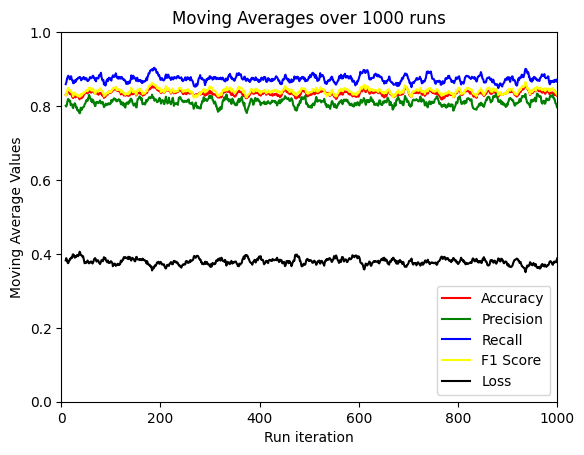

In [79]:
## Moving average for all results

print(f'Accuracy mean - {np.mean(accuracyCollection)}')
print(f'Precision mean - {np.mean(precisionCollection)}')
print(f'Recall mean - {np.mean(recallCollection)}')
print(f'F1 Score mean - {np.mean(f1_scoreCollection)}')
print(f'Loss mean - {np.mean(lossCollection)}')

seriesAccuracy = pd.Series(accuracyCollection)
seriesPrecision = pd.Series(precisionCollection)
seriesRecall = pd.Series(recallCollection)
seriesf1_score = pd.Series(f1_scoreCollection)
seriesLoss = pd.Series(lossCollection)

movingAccuracy = seriesAccuracy.rolling(window=10).mean()
movingPrecision = seriesPrecision.rolling(window=10).mean()
movingRecall = seriesRecall.rolling(window=10).mean()
movingF1_score = seriesf1_score.rolling(window=10).mean()
movingLoss = seriesLoss.rolling(window=10).mean()



x = range(len(movingAccuracy))
fig, ax = plt.subplots()

ax.plot(x, movingAccuracy, color='red', label='Accuracy')
ax.plot(x, movingPrecision, color='green', label='Precision')
ax.plot(x, movingRecall, color='blue', label='Recall')
ax.plot(x, movingF1_score, color='yellow', label='F1 Score')
ax.plot(x, movingLoss, color='black', label='Loss')

ax.set_ylim([0, 1])
ax.set_xlim([0, 1000])

# set the title, x-axis label, and y-axis label
ax.set_title('Moving Averages over 1000 runs')
ax.set_xlabel('Run iteration')
ax.set_ylabel('Moving Average Values')

# add a legend
ax.legend(loc='lower right')

# show the plot
plt.show()


[[89 14]
 [ 4 93]]


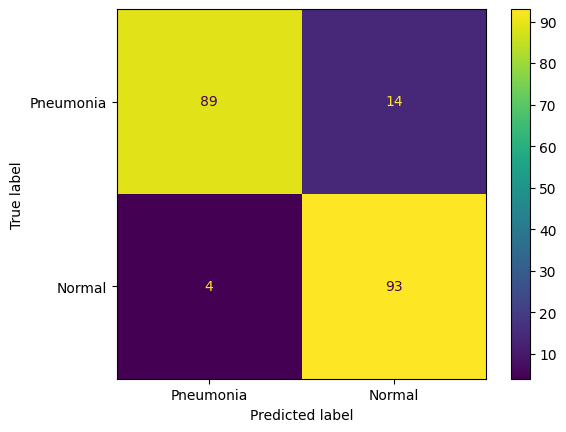

In [74]:
## Confusion Matrix
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Pneumonia","Normal"])
disp.plot()
plt.show()

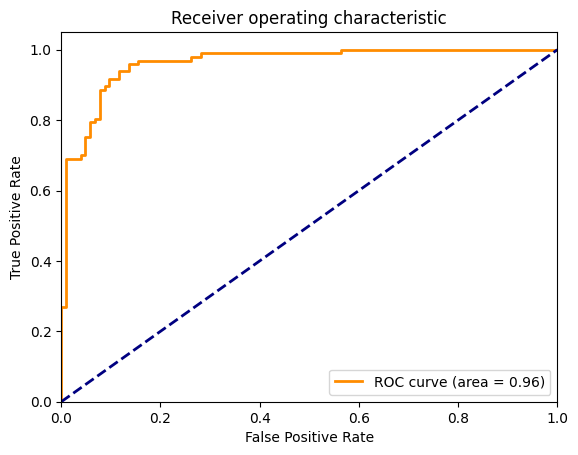

In [72]:
##ROC Curve

# Get the predicted labels
predictions = (activation4.output > 0.5) * 1

# Calculate confusion matrix
cm = confusion_matrix(testing_labels_sample, predictions)

# Calculate true positive rate and false positive rate for ROC curve
fpr, tpr, thresholds = roc_curve(testing_labels_sample, activation4.output)

# calculate the fpr and tpr for all thresholds of the classification
probs = activation4.output # the probabilities from the model
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
print(roc_auc)

plt.show()